<a href="https://colab.research.google.com/github/AndyDengFKu/DPA2/blob/main/SEResNeXt50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset, random_split, Subset, SubsetRandomSampler, TensorDataset
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from PIL import Image
import h5py
import numpy as np
import copy
import torch
import time
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define SEModule for the Squeeze-and-Excitation operation
class SEModule(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

# Define the basic block for SEResNeXt
class SEResNeXtBottleneck(nn.Module):
    expansion = 5

    def __init__(self, in_channels, out_channels, stride, cardinality, base_width, reduction):
        super(SEResNeXtBottleneck, self).__init__()
        width = int(out_channels * (base_width / 64.)) * cardinality
        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(out_channels * self.expansion, reduction=reduction)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion)
        )
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.se_module(out)

        residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# Define the SEResNeXt50 model
class SEResNeXt50(nn.Module):
    def __init__(self, num_classes=2, cardinality=32, base_width=4, reduction=16, intermediate_dim=64):
        super(SEResNeXt50, self).__init__()
        self.in_channels = 64
        self.cardinality = cardinality
        self.base_width = base_width
        self.reduction = reduction

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.4)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Bottleneck
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(512 * SEResNeXtBottleneck.expansion, intermediate_dim)
        self.bn1_fc = nn.BatchNorm1d(intermediate_dim)
        self.elu = nn.ELU()

        self.fc2 = nn.Linear(intermediate_dim, num_classes)


    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(SEResNeXtBottleneck(self.in_channels, out_channels, stride=stride,
                                          cardinality=self.cardinality, base_width=self.base_width, reduction=self.reduction))
        self.in_channels = out_channels * SEResNeXtBottleneck.expansion
        for i in range(1, blocks):
            layers.append(SEResNeXtBottleneck(self.in_channels, out_channels, stride=1,
                                              cardinality=self.cardinality, base_width=self.base_width, reduction=self.reduction))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn1_fc(x)
        x = self.elu(x)
        x = self.dropout(x)
        x = self.fc2(x)


        return x

# Instantiate the model
model = SEResNeXt50(num_classes=1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
with h5py.File('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/Padding_WSI_data.h5', 'r') as hf:
    train_images = hf['train_images'][:]
    train_labels = hf['train_labels'][:]
    val_images = hf['val_images'][:]
    val_labels = hf['val_labels'][:]

In [ ]:
class WSIDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


train_dataset = WSIDataset(train_images, train_labels)
val_dataset = WSIDataset(val_images, val_labels)

In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load one batch of training data
images, labels = next(iter(train_loader))

# Print the shapes of images and labels
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Images shape: torch.Size([64, 3, 64, 64])
Labels shape: torch.Size([64])


In [ ]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SEResNeXt50(num_classes=1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()
M = 2  # number of snapshots
alpha_zero = 0.01  # initial learning rate
epochs = 10
warmup_epochs = 3  # number of epochs for the warm-up

class SnapshotCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, M, eta_min=0, warmup_epochs=0, last_epoch=-1):
        self.T_max = T_max
        self.M = M
        self.eta_min = eta_min
        self.warmup_epochs = warmup_epochs
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            return [(self.last_epoch+1)/self.warmup_epochs * base_lr for base_lr in self.base_lrs]

        curr_epoch = self.last_epoch - self.warmup_epochs
        i = int(curr_epoch // self.T_max)
        t = curr_epoch % self.T_max / self.T_max
        lr_list = []
        for base_lr in self.base_lrs:
          eta_t = self.eta_min + (base_lr - self.eta_min) * (1 + np.cos(np.pi * t)) / 2
          lr_list.append(i % self.M * eta_t + (self.M - i % self.M - 1) * base_lr)

        return lr_list

scheduler = SnapshotCosineAnnealingLR(optimizer, T_max=epochs//M, M=M, warmup_epochs=warmup_epochs)

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta
        self.early_stop = False

    def __call__(self, val_loss, model, model_path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, model_path):
        torch.save(model.state_dict(), model_path)
        print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')

early_stopping = EarlyStopping(patience=5)

def load_data_for_fold(fold_num, kf, dataset):

    train_idx, val_idx = list(kf.split(range(len(dataset))))[fold_num]
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)
    return train_loader, val_loader

def train_one_epoch(train_loader, model, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        start_time = time.time()

        images, labels = images.to(device), labels.to(device)
        #print("Data Loading Time:", time.time() - start_time)

        start_time = time.time()
        optimizer.zero_grad()
        outputs = model(images)
        #print("Forward Pass Time:", time.time() - start_time)

        start_time = time.time()
        loss = criterion(outputs.view(-1), labels.float())
        loss.backward()
        optimizer.step()
        #print("Backward Pass Time:", time.time() - start_time)

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss



def validate(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs.view(-1), labels.float())

            running_loss += loss.item() * images.size(0)
            all_preds.extend(outputs.view(-1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    auc_score = roc_auc_score(all_labels, all_preds)

    return epoch_loss, auc_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_val_losses = []
all_val_aucs = []


for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Training for fold {fold+1}")

    train_loader, val_loader = load_data_for_fold(fold, kf, train_dataset)

    model = SEResNeXt50(num_classes=1).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = SnapshotCosineAnnealingLR(optimizer, T_max=epochs//M, M=M, warmup_epochs=warmup_epochs)
    early_stopping = EarlyStopping(patience=5)

    best_auc = 0
    model_path = f'/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/backup_SEResNeXt50_model_fold_{fold+1}.pth'

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):
        train_loss = train_one_epoch(train_loader, model, optimizer, criterion, device)
        val_loss, val_auc = validate(val_loader, model, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)

        print(f'Epoch {epoch}/{epochs-1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        scheduler.step()  # Update learning rate

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), model_path)

        early_stopping(val_loss, model, model_path)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Append the losses and AUCs for this fold to the overall lists
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_val_aucs.append(val_aucs)

    df_fold = pd.DataFrame({
        'Train Loss': train_losses,
        'Val Loss': val_losses,
        'Val AUC': val_aucs
    })
    save_path_fold = f'/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/backup_train_data_fold_{fold+1}.csv'
    df_fold.to_csv(save_path_fold)

    print(f"Data for fold {fold+1} saved to {save_path_fold}")


Training for fold 1
Epoch 0/9, Train Loss: 0.4692, Val Loss: 0.4359, Val AUC: 0.8790
Validation loss decreased (-0.435885 --> 0.435885).  Saving model ...
Epoch 1/9, Train Loss: 0.4247, Val Loss: 0.4522, Val AUC: 0.8953
EarlyStopping counter: 1 out of 5
Epoch 2/9, Train Loss: 0.4013, Val Loss: 0.4037, Val AUC: 0.9058
Validation loss decreased (-0.403705 --> 0.403705).  Saving model ...
Epoch 3/9, Train Loss: 0.3821, Val Loss: 0.3732, Val AUC: 0.9137
Validation loss decreased (-0.373231 --> 0.373231).  Saving model ...
Epoch 4/9, Train Loss: 0.3699, Val Loss: 0.5627, Val AUC: 0.8984
EarlyStopping counter: 1 out of 5
Epoch 5/9, Train Loss: 0.3588, Val Loss: 0.4746, Val AUC: 0.9106
EarlyStopping counter: 2 out of 5
Epoch 6/9, Train Loss: 0.3532, Val Loss: 0.4029, Val AUC: 0.9205
EarlyStopping counter: 3 out of 5
Epoch 7/9, Train Loss: 0.3445, Val Loss: 0.3704, Val AUC: 0.9237
Validation loss decreased (-0.370378 --> 0.370378).  Saving model ...
Epoch 8/9, Train Loss: 0.3382, Val Loss: 0.3

In [ ]:
# Now, save the data for all folds to a CSV
index = pd.MultiIndex.from_product([range(n_splits), range(epochs)], names=['Fold', 'Epoch'])
df = pd.DataFrame(index=index)
df['Train Loss'] = [loss for sublist in all_train_losses for loss in sublist]
df['Val Loss'] = [loss for sublist in all_val_losses for loss in sublist]
df['Val AUC'] = [auc for sublist in all_val_aucs for auc in sublist]
save_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/backup_train_data_all_folds.csv'
df.to_csv(save_path)


In [ ]:
print(df.columns)

Index(['Fold', 'Epoch', 'Train Loss', 'Val Loss', 'Val AUC'], dtype='object')


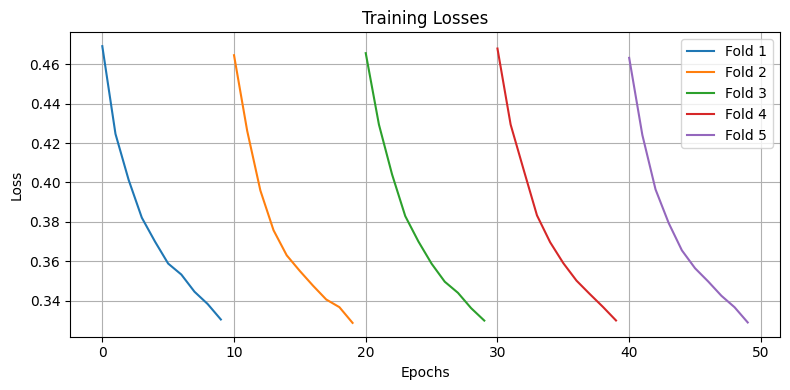

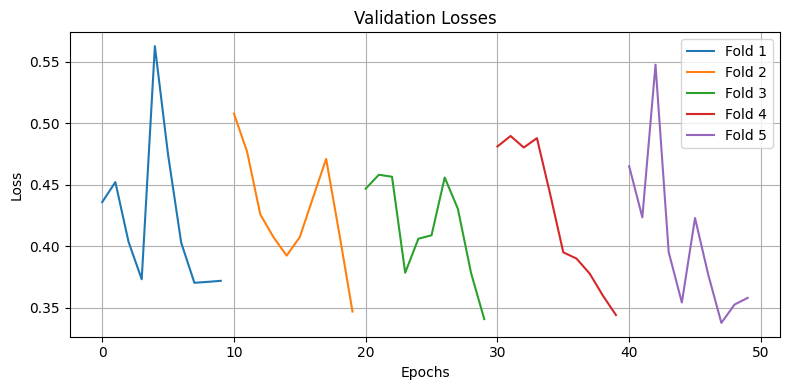

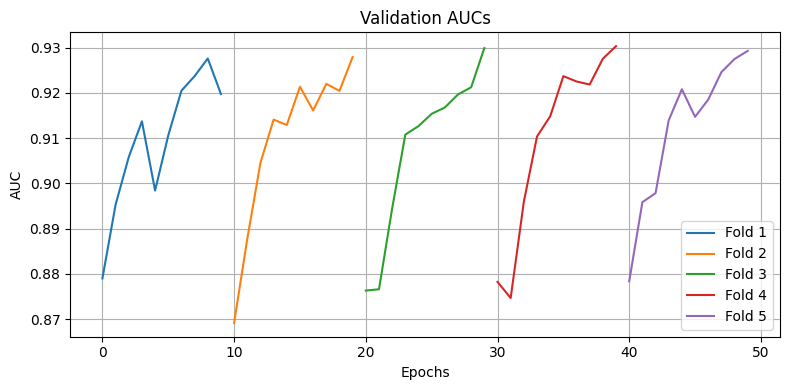

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/backup_train_data_all_folds.csv')

plt.figure(figsize=(8, 4))

for fold in range(5):
    plt.plot(df['Train Loss'].loc[df['Fold'] == fold], label=f'Fold {fold+1}')

plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_losses.png')
plt.show()

plt.figure(figsize=(8, 4))
for fold in range(5):
    plt.plot(df['Val Loss'].loc[df['Fold'] == fold], label=f'Fold {fold+1}')

plt.title('Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('validation_losses.png')
plt.show()

plt.figure(figsize=(8, 4))
for fold in range(5):
    plt.plot(df['Val AUC'].loc[df['Fold'] == fold], label=f'Fold {fold+1}')

plt.title('Validation AUCs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('validation_aucs.png')
plt.show()



Precision: 0.8063
Recall: 0.8733
F1 Score: 0.8385
Accuracy: 0.8644
ROC AUC: 0.9412


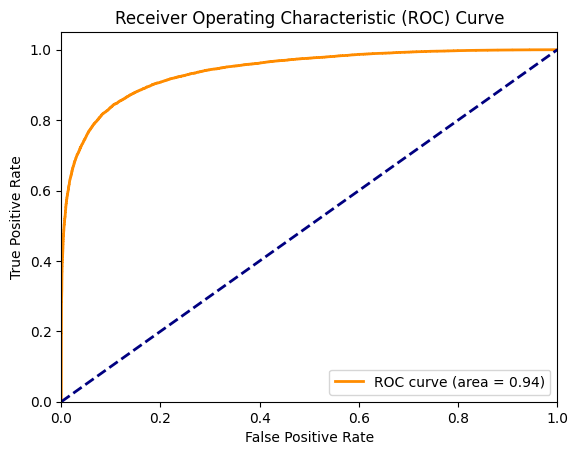

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = []
for fold in range(5):
    model = SEResNeXt50(num_classes=1).to(device)
    model_path = f'/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/backup_SEResNeXt50_model_fold_{fold+1}.pth'
    model.load_state_dict(torch.load(model_path))
    model.eval()
    models.append(model)

all_labels = []
ensemble_predictions = []

for images, labels in val_loader:
    images = images.to(device)
    ensemble_output = torch.zeros_like(labels).float().to(device)
    with torch.no_grad():
        for model in models:
            outputs = model(images)
            probabilities = torch.sigmoid(outputs).squeeze()
            ensemble_output += probabilities
    ensemble_output /= len(models)
    ensemble_predictions.extend(ensemble_output.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
threshold = 0.5
binary_predictions = np.array(ensemble_predictions) > threshold

precision = precision_score(all_labels, binary_predictions)
recall = recall_score(all_labels, binary_predictions)
f1 = f1_score(all_labels, binary_predictions)
accuracy = accuracy_score(all_labels, binary_predictions)


fpr, tpr, _ = roc_curve(all_labels, ensemble_predictions)
roc_auc = auc(fpr, tpr)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import h5py
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

def ensemble_prediction(test_loader, model_paths, device):
    models = [SEResNeXt50(num_classes=1).to(device) for _ in model_paths]

    # Load models from paths
    for model, path in zip(models, model_paths):
        model.load_state_dict(torch.load(path))
        model.eval()

    all_predictions = []
    with torch.no_grad():
        for batch in test_loader:
            images = batch[0].to(device)
            # Average predictions from all models
            logits = torch.mean(torch.stack([model(images) for model in models]), dim=0)
            probabilities = torch.sigmoid(logits).squeeze()
            all_predictions.extend(probabilities.cpu().numpy())

    return np.array(all_predictions)


In [ ]:
with h5py.File("/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/new_test.hdf5", "r") as f:
    keys = list(f.keys())
    images = np.stack([f[key][...] for key in keys])

test_dataset = TensorDataset(torch.tensor(images, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
model_paths = [f'/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/backup_SEResNeXt50_model_fold_{fold+1}.pth' for i in range(5)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

predictions = ensemble_prediction(test_loader, model_paths, device)
binary_labels = (predictions > 0.5).astype(int)

In [ ]:
df = pd.DataFrame({
    'id': [key.replace('.tif', '') for key in keys],
    'label': binary_labels  # Use the binary labels here instead of raw predictions
})
df.to_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/predictions.csv', index=False)


In [ ]:
model = SEResNeXt50(num_classes=1)

def find_conv_layers(module):
    for name, child in module.named_children():
        if isinstance(child, nn.Conv2d):
            print(f"Layer Name: {name}, Out Channels: {child.out_channels}")
        else:
            find_conv_layers(child)

find_conv_layers(model)
